<a href="https://colab.research.google.com/github/Anze-/datathon2k25/blob/alberto/feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Engineering

# 1. Set up working environment

In [4]:
import pandas as pd
import numpy as np
import csv

In [5]:
# enable GPU if needed, GPU can speed up your vector embedding if you computing these vectors locally (not using API)

import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [6]:
import os
import json
import chromadb
import openai
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.llms import OpenAI
from langchain.chains import RetrievalQA

# Set OpenAI API Key
#os.environ["OPENAI_API_KEY"] = open('api.key').read()[:-1]

# 2. Working on URLs

In [7]:
!ls

1			    filtered_urls.parquet  README.md
2025-04-05-Note-10-07.xopp  frontend		   url_filtering.ipynb
data			    labelurls.txt	   uv.lock
env.yml			    main.py
feature_engineering.ipynb   pyproject.toml


In [8]:
folder_path = "./data/hackathon_data/"# Google drive path of the dataset
files_in_folder = os.listdir(folder_path)
len(files_in_folder)

13144

In [9]:
def load_documents(json_file):
    """Loads the JSON file."""
    with open(json_file, 'r') as f:
      try:
          data = json.load(f)
          return data
      except json.JSONDecodeError:
          print(f"Error reading {json_file}, it may not be a valid JSON file.")
    return []

In [10]:
def load_urls(file=files_in_folder[0]):
    website_name=file[:-5]
    urldocs=load_documents(folder_path+file)['text_by_page_url']
    return {website_name:list(urldocs.keys())}

In [11]:
load_urls(files_in_folder[0])

{'brewingz.com': ['http://brewingz.com',
  'https://brewingz.com/',
  'https://brewingz.com/menu/',
  'https://brewingz.com/lunch-specials/',
  'https://brewingz.com/bundles/',
  'https://brewingz.com/kids-menu/',
  'https://brewingz.com/happy-hour/',
  'http://brewingz.com/bardrinks/',
  'https://brewingz.com/party-platter/',
  'https://brewingz.com/locations-2/',
  'https://brewingz.com/brewingz-gift-card/',
  'https://brewingz.com/specials/',
  'http://brewingz.com/events/?a=1',
  'https://brewingz.com/whats-happening/',
  'http://brewingz.com/12-days-of-christmas-giveaways/',
  'https://brewingz.com/290-at-tidwell-marketplace/',
  'https://brewingz.com/baytown/',
  'https://brewingz.com/beechnut-at-i-59/',
  'https://brewingz.com/federal/',
  'https://brewingz.com/fuqua-at-i-45/',
  'https://brewingz.com/humble/',
  'https://brewingz.com/katy/',
  'https://brewingz.com/kingwood/',
  'https://brewingz.com/pasadena/',
  'https://brewingz.com/cr-59-at-288/',
  'https://brewingz.com/pe

In [12]:
#choose a labeling set

np.random.seed(42)
labeling_set = np.random.choice(files_in_folder,100)

In [13]:
labelurls = []
for L in [list(load_urls(site).values())[0] for site in labeling_set]:
    labelurls.extend(L)

In [14]:
labelurls

['http://getcrg.com',
 'https://www.getcrg.com',
 'https://www.getcrg.com/',
 'http://getcrg.com/staffing/',
 'http://getcrg.com/staffing/process/',
 'http://getcrg.com/staffing/services/',
 'http://getcrg.com/staffing/leadership/',
 'https://www.getcrg.com/candidate-support/',
 'https://www.getcrg.com/locations/',
 'https://www.getcrg.com/about/leadership/',
 'https://www.getcrg.com/about/crg-values/',
 'https://www.getcrg.com/about/community-focus/',
 'https://www.getcrg.com/about/crg-awards/',
 'https://www.getcrg.com/blog/',
 'https://www.getcrg.com/get-started/',
 'http://www.getcrg.com/staffing',
 'https://www.getcrg.com/staffing/contact-us/',
 'https://www.getcrg.com/crg-values/',
 'https://www.getcrg.com/search-leadership/',
 'https://www.getcrg.com/our-process/',
 'https://www.getcrg.com/staffing-process/',
 'https://www.getcrg.com/wp-content/themes/uncode/library/css/style.css?ver=1946684731',
 'https://www.getcrg.com/wp-content/themes/uncode/library/css/style-custom.css?ver=

## tokenizer

In [16]:
# tokenizer

import tldextract
from urllib.parse import urlparse, parse_qs

def simple_url_tokenizer(url: str):
    # 1. Parse the URL with urllib to get basic components
    parsed_url = urlparse(url)
    
    # 2. Use tldextract to get domain/subdomain
    extracted = tldextract.extract(url)
    
    # 3. Extract components
    scheme = parsed_url.scheme    # 'http', 'https', etc.
    domain = extracted.domain      # 'example'
    subdomain = extracted.subdomain  # 'www'
    path = parsed_url.path        # '/path/to/resource'
    query = parsed_url.query      # 'id=123&name=abc'
    depth = path.count("/")
    # 4. Tokenize path (split into parts by '/')
    path_tokens = path.strip('/').split('/') if path else []
    path_tokens = [tk.split('-') for tk in path_tokens]
    path_tokens = sum(path_tokens,[]) + [scheme]
    concat_tokens = " ".join(path_tokens)



    # 5. Tokenize query parameters (key-value pairs)
    query_tokens = {k: v[0] for k, v in parse_qs(query).items()} if query else {}

    # Return all tokens in a dictionary
    return {
        #'scheme': scheme,
        #'subdomain': subdomain,
        #'domain': domain,
        'path_tokens': concat_tokens,
        'depth': depth
        #'query_tokens': query_tokens
    }

In [17]:
train_url_texts = []
train_url_depth = []



# Apply the tokenizer to each URL
for url in labelurls:
    tokens = simple_url_tokenizer(url)
    print(f"Tokens for URL: {url}")
    print(tokens)
    print("-" * 50)
    train_url_texts.append(tokens["path_tokens"])
    train_url_depth.append(tokens["depth"])

train_url_texts


Tokens for URL: http://getcrg.com
{'path_tokens': 'http', 'depth': 0}
--------------------------------------------------
Tokens for URL: https://www.getcrg.com
{'path_tokens': 'https', 'depth': 0}
--------------------------------------------------
Tokens for URL: https://www.getcrg.com/
{'path_tokens': ' https', 'depth': 1}
--------------------------------------------------
Tokens for URL: http://getcrg.com/staffing/
{'path_tokens': 'staffing http', 'depth': 2}
--------------------------------------------------
Tokens for URL: http://getcrg.com/staffing/process/
{'path_tokens': 'staffing process http', 'depth': 3}
--------------------------------------------------
Tokens for URL: http://getcrg.com/staffing/services/
{'path_tokens': 'staffing services http', 'depth': 3}
--------------------------------------------------
Tokens for URL: http://getcrg.com/staffing/leadership/
{'path_tokens': 'staffing leadership http', 'depth': 3}
--------------------------------------------------
Tokens 

['http',
 'https',
 ' https',
 'staffing http',
 'staffing process http',
 'staffing services http',
 'staffing leadership http',
 'candidate support https',
 'locations https',
 'about leadership https',
 'about crg values https',
 'about community focus https',
 'about crg awards https',
 'blog https',
 'get started https',
 'staffing http',
 'staffing contact us https',
 'crg values https',
 'search leadership https',
 'our process https',
 'staffing process https',
 'wp content themes uncode library css style.css https',
 'wp content themes uncode library css style custom.css https',
 'wp content themes uncode library css style.css https',
 'wp content themes uncode library css style custom.css https',
 'staffing services https',
 'it staffing https',
 'accounting recruitment https',
 'contact us staffing https',
 'wp content themes uncode library css style.css https',
 'wp content themes uncode library css style custom.css https',
 'blog 15 step recruitment process explained https

In [18]:
import pandas as pd

labels_for_urls = pd.read_csv("./data/labled_urls.csv")
labels_for_urls.drop("Unnamed: 1", axis=1, inplace=True)
train_url_labels = labels_for_urls["0"]

FileNotFoundError: [Errno 2] No such file or directory: './data/labled_urls.csv'

## model

In [19]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

import scipy.sparse as sparse


# 1. Convert text to features using TF-IDF vectorization
vectorizer = TfidfVectorizer()
# 2. Vectorize the text data

X = sparse.hstack([vectorizer.fit_transform(train_url_texts[:len(train_url_labels)]), np.array(train_url_depth[:len(train_url_labels)]).reshape(-1,1)]  )

# 3. Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, train_url_labels, test_size=0.2, shuffle=True, random_state=42)

# 4. Initialize and train the Logistic Regression model
model = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=42, solver="lbfgs")
model.fit(X_train, y_train)

# 5. Make predictions on the test set
y_pred = model.predict(X_test)

# 6. Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print results
print("Accuracy:", accuracy)
print("Classification Report:")
print(class_report)





NameError: name 'train_url_labels' is not defined

In [24]:
from tqdm import tqdm
def prepare_urls(urls):
    url_texts=[]
    url_depth=[]
    for url in urls:
        tokens = simple_url_tokenizer(url)
        url_texts.append(tokens["path_tokens"])
        url_depth.append(tokens["depth"])

    X = sparse.hstack([vectorizer.transform(url_texts), np.array(url_depth).reshape(-1,1)])

    return X

def is_url_important(urls):
    X=  prepare_urls(urls)
    predicted_vals =  model.predict(X)
    return predicted_vals == 1

In [25]:
urls = [list(load_urls(site).values())[0] for site in tqdm(files_in_folder)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13144/13144 [05:22<00:00, 40.76it/s]


In [26]:
from itertools import chain

flattened_urls = list(chain.from_iterable(urls))
flattened_urls

['http://brewingz.com',
 'https://brewingz.com/',
 'https://brewingz.com/menu/',
 'https://brewingz.com/lunch-specials/',
 'https://brewingz.com/bundles/',
 'https://brewingz.com/kids-menu/',
 'https://brewingz.com/happy-hour/',
 'http://brewingz.com/bardrinks/',
 'https://brewingz.com/party-platter/',
 'https://brewingz.com/locations-2/',
 'https://brewingz.com/brewingz-gift-card/',
 'https://brewingz.com/specials/',
 'http://brewingz.com/events/?a=1',
 'https://brewingz.com/whats-happening/',
 'http://brewingz.com/12-days-of-christmas-giveaways/',
 'https://brewingz.com/290-at-tidwell-marketplace/',
 'https://brewingz.com/baytown/',
 'https://brewingz.com/beechnut-at-i-59/',
 'https://brewingz.com/federal/',
 'https://brewingz.com/fuqua-at-i-45/',
 'https://brewingz.com/humble/',
 'https://brewingz.com/katy/',
 'https://brewingz.com/kingwood/',
 'https://brewingz.com/pasadena/',
 'https://brewingz.com/cr-59-at-288/',
 'https://brewingz.com/pearlandpkwy/',
 'https://brewingz.com/silbe

In [27]:
urls_df = pd.DataFrame(flattened_urls, columns=["url"])
urls_df.head()


,url
0,http://brewingz.com
1,https://brewingz.com/
2,https://brewingz.com/menu/
3,https://brewingz.com/lunch-specials/
4,https://brewingz.com/bundles/


In [28]:
filtering_usage = is_url_important(flattened_urls)
filtering_usage.sum()

NotFittedError: The TF-IDF vectorizer is not fitted

In [32]:
#urls_df["is_filtered"] = filtering_usage
urls_df.to_parquet("filtered_urls.parquet")

## Duplicates removal

In [33]:
urls_df = pd.read_parquet("filtered_urls.parquet")

In [34]:
urls_df[urls_df.is_filtered==True]

AttributeError: 'DataFrame' object has no attribute 'is_filtered'

In [35]:
# ok, it looks bad, let's filter with other criteria

In [36]:
urls_df['splits'] = urls_df.url.apply(lambda x: x.split('/'))

In [37]:
urls_df['num_splits'] = urls_df.splits.apply(len)

<Axes: >

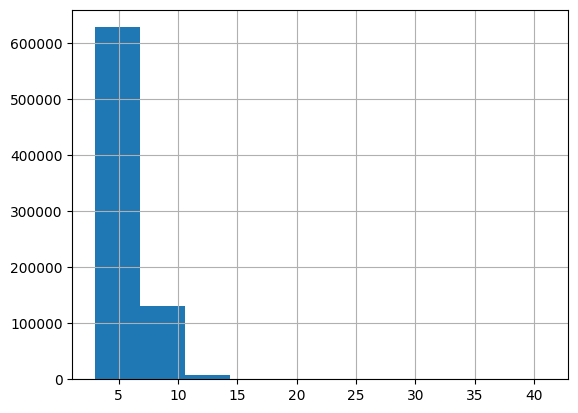

In [38]:
urls_df.num_splits.hist()

In [39]:
urls_df1=urls_df[urls_df['num_splits']<7]

In [40]:
trigger = '.css'
for trigger,name in zip(['.js','.css','/blog/','/article/','/post/','/news/'],['is_js','is_css','is_blog','is_article','is_post','is_news']):
    urls_df1[name] = urls_df1.url.apply(lambda x: trigger in x)

/tmp/ipykernel_244096/2222979193.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  urls_df1[name] = urls_df1.url.apply(lambda x: trigger in x)
/tmp/ipykernel_244096/2222979193.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  urls_df1[name] = urls_df1.url.apply(lambda x: trigger in x)
/tmp/ipykernel_244096/2222979193.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [41]:
urls_df1

,url,splits,num_splits,is_js,is_css,is_blog,is_article,is_post,is_news
0,http://brewingz.com,"[http:, , brewingz.com]",3,False,False,False,False,False,False
1,https://brewingz.com/,"[https:, , brewingz.com, ]",4,False,False,False,False,False,False
2,https://brewingz.com/menu/,"[https:, , brewingz.com, menu, ]",5,False,False,False,False,False,False
3,https://brewingz.com/lunch-specials/,"[https:, , brewingz.com, lunch-specials, ]",5,False,False,False,False,False,False
4,https://brewingz.com/bundles/,"[https:, , brewingz.com, bundles, ]",5,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
768473,http://southernnuclear.com/news-center/vogtle-...,"[http:, , southernnuclear.com, news-center, vo...",5,False,False,False,False,False,False
768474,http://southernnuclear.com/news-center/vogtle-...,"[http:, , southernnuclear.com, news-center, vo...",6,False,False,False,False,False,False
768475,http://southernnuclear.com/news-center/vogtle-...,"[http:, , southernnuclear.com, news-center, vo...",6,False,False,False,False,False,False
768476,http://southernnuclear.com/careers.html,"[http:, , southernnuclear.com, careers.html]",4,False,False,False,False,False,False


In [43]:
urls_df2 = urls_df1[(urls_df1.is_css==False) & (urls_df1.is_js==False)  & (urls_df1.is_blog==False) & (urls_df1.is_article==False) & (urls_df1.is_post==False) & (urls_df1.is_news==False)]

In [44]:
#remove HTTP/S duplicates

# Step 1: Create a normalized column (strip http/https)
urls_df2['normalized'] = urls_df2['url'].str.replace(r'^https?://', '', regex=True)

# Step 2: Sort so that https comes first (we want to keep https)
urls_df2['https_first'] = urls_df2['url'].str.startswith('https')
urls_df2 = urls_df2.sort_values(by='https_first', ascending=False)

# Step 3: Drop duplicates based on normalized version, keeping the first (https preferred)
urls_df2 = urls_df2.drop_duplicates(subset='normalized', keep='first')

# Step 4: Drop helper columns
urls_df3 = urls_df2.drop(columns=['normalized', 'https_first'])

/tmp/ipykernel_244096/3706498202.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  urls_df2['normalized'] = urls_df2['url'].str.replace(r'^https?://', '', regex=True)
/tmp/ipykernel_244096/3706498202.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  urls_df2['https_first'] = urls_df2['url'].str.startswith('https')


In [45]:
# remove trailing slash

# Step 1: Normalize by removing scheme and trailing slash
urls_df3['normalized'] = urls_df3['url'].str.replace(r'^https?://', '', regex=True).str.rstrip('/')

# Step 2: Prefer https (create boolean flags)
urls_df3['is_https'] = urls_df3['url'].str.startswith('https')
urls_df3['no_trailing_slash'] = ~urls_df3['url'].str.endswith('/')

# Step 3: Sort to prefer https and no trailing slash
urls_df3 = urls_df3.sort_values(by=['is_https', 'no_trailing_slash'], ascending=[False, False])

# Step 4: Drop duplicates on normalized version
urls_df3 = urls_df3.drop_duplicates(subset='normalized', keep='first')

# Step 5: Clean up
urls_df3 = urls_df3.drop(columns=['normalized', 'is_https', 'no_trailing_slash'])

In [46]:
# now lets find pages that we are interested in

In [47]:
home_urls = urls_df3[urls_df3.num_splits==3]
about_urls = urls_df3[urls_df3.splits.apply(lambda x : 'about' in ' '.join(x[3:]) )]
contact_urls = urls_df3[urls_df3.splits.apply(lambda x : 'contact' in ' '.join(x[3:]) )]
technology_urls = urls_df3[urls_df3.splits.apply(lambda x : 'technology' in ' '.join(x[3:]) )]
product_urls = urls_df3[urls_df3.splits.apply(lambda x : 'product' in ' '.join(x[3:]) )]
service_urls = urls_df3[urls_df3.splits.apply(lambda x : 'service' in ' '.join(x[3:]) )]
work_urls = urls_df3[urls_df3.splits.apply(lambda x : 'work' in ' '.join(x[3:]) )]
capability_urls = urls_df3[urls_df3.splits.apply(lambda x : 'capabil' in ' '.join(x[3:]) )]
industry_urls = urls_df3[urls_df3.splits.apply(lambda x : 'industr' in ' '.join(x[3:]) )]

In [48]:
keyword_dfs = [home_urls,about_urls,contact_urls,technology_urls,product_urls,service_urls,work_urls,capability_urls,industry_urls]

In [49]:
keyword_dfs

[                                      url  \
 642660          https://www.statisllc.com   
 313925  https://www.sportsmanboatsmfg.com   
 642801       https://www.flytradewind.com   
 313648   https://longbridge-financial.com   
 642310                https://www.act.com   
 ...                                   ...   
 365930               http://expertise.com   
 365706                  http://novata.com   
 365776      http://stlukessurreyplace.com   
 366145            http://rainforestqa.com   
 366000             http://unisourceit.com   
 
                                        splits  num_splits  is_js  is_css  \
 642660          [https:, , www.statisllc.com]           3  False   False   
 313925  [https:, , www.sportsmanboatsmfg.com]           3  False   False   
 642801       [https:, , www.flytradewind.com]           3  False   False   
 313648   [https:, , longbridge-financial.com]           3  False   False   
 642310                [https:, , www.act.com]           3  F

In [50]:
len(keyword_dfs)

9

In [51]:
from urllib.parse import urlparse

def get_domain(url):
    return urlparse(url).netloc

# Process each DataFrame
processed_dfs = []
for df in keyword_dfs:
    df['domain'] = df['url'].apply(get_domain)
    # Keep the row with the smallest num_splits per domain
    df_grouped = df.loc[df.groupby('domain')['num_splits'].idxmin()]
    processed_dfs.append(df_grouped.drop(columns='domain'))  # drop helper column if not needed

/tmp/ipykernel_244096/3210399472.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['domain'] = df['url'].apply(get_domain)
/tmp/ipykernel_244096/3210399472.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['domain'] = df['url'].apply(get_domain)
/tmp/ipykernel_244096/3210399472.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [52]:
combined_df = pd.concat(processed_dfs, ignore_index=True)
combined_df = combined_df.drop_duplicates(subset='url')

In [53]:
combined_df['domain'] = combined_df['url'].apply(get_domain)

In [54]:
combined_df

,url,splits,num_splits,is_js,is_css,is_blog,is_article,is_post,is_news,domain
0,https://1-vision.com,"[https:, , 1-vision.com]",3,False,False,False,False,False,False,1-vision.com
1,http://100coaches.com,"[http:, , 100coaches.com]",3,False,False,False,False,False,False,100coaches.com
2,https://101financial.com,"[https:, , 101financial.com]",3,False,False,False,False,False,False,101financial.com
3,http://1021creative.com,"[http:, , 1021creative.com]",3,False,False,False,False,False,False,1021creative.com
4,https://10roadsexpress.com,"[https:, , 10roadsexpress.com]",3,False,False,False,False,False,False,10roadsexpress.com
...,...,...,...,...,...,...,...,...,...,...
49909,https://www.wirtzusa.com/equipments/wirtz-indu...,"[https:, , www.wirtzusa.com, equipments, wirtz...",6,False,False,False,False,False,False,www.wirtzusa.com
49910,https://www.woh.com/industries/,"[https:, , www.woh.com, industries, ]",5,False,False,False,False,False,False,www.woh.com
49911,https://www.wsinc.com/industry/paper/,"[https:, , www.wsinc.com, industry, paper, ]",6,False,False,False,False,False,False,www.wsinc.com
49912,https://www.wvpa.com/industry-expertise/,"[https:, , www.wvpa.com, industry-expertise, ]",5,False,False,False,False,False,False,www.wvpa.com


In [55]:
combined_df.to_parquet("important_urls.parquet")